In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit
from astropy.coordinates import SkyCoord
import astropy.units as u

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from scipy.stats import gaussian_kde

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

In [5]:
# DATA
# ======
# LINEAR data
dataL = fetch_LINEAR_sample(data_home='../inputs')

# calcualted data
end = 'ffinal'

# light curve table
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
# rr lyrae
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
# blazhko candidates
blazhko_candidates = pd.read_csv('../outputs/blazhko_canmodfinal.csv')
# periodogram data
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
# fits data
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
# ztf data
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

# selection data
ztf_per = pd.read_csv('../outputs/groupZ_p.csv')
linear_per = pd.read_csv('../outputs/groupL_p.csv')
score = pd.read_csv('../outputs/group_score.csv')

In [6]:
FINAL_BE_CATALOGUE = pd.read_csv('../outputs/be_final.csv')

---

In this notebook we analyze Blazhko stars found during this work, and all our results are summarized in the paper.

# Analysis of the final catalogue

### Adding the light curve type

In [7]:
lctype = []

for i in range(len(list(rrlyrae['LINEARobjectID']))):
    lctype.append((rrlyrae['LINEARobjectID'][i], rrlyrae['LCtype'][i]))

be_lctype = []
for i in list(lc_analysis['LINEAR id']):
    for n in lctype:
        if i==n[0]:
            be_lctype.append(n)
print(len(be_lctype))

LCTYPE = [x[1] for x in be_lctype]

lc_analysis['LCtype'] = LCTYPE
lc_analysis.head()

2857


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,LCtype
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN,1
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN,1
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN,1
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN,1
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN,2


### Creating the master table

In [8]:
lc_MASTER = pd.DataFrame(())
lc_MASTER['LINEAR ID'] = lc_analysis['LINEAR id']
lc_MASTER['Plinear'] = lc_analysis['Plinear']
lc_MASTER['Pztf'] = lc_analysis['Pztf']
lc_MASTER['N_L'] = lc_analysis['NdataLINEAR']
lc_MASTER['N_Z'] = lc_analysis['NdataZTF']
lc_MASTER['L_chi2r'] = lc_analysis['L_chi2dofR']
lc_MASTER['Z_chi2r'] = lc_analysis['Zchi2dofR']
lc_MASTER['L_chi2'] = lc_analysis['L_chi2dof']
lc_MASTER['Z_chi2'] = lc_analysis['Zchi2dof']
lc_MASTER['Lampl'] = lc_analysis['Lampl']
lc_MASTER['Zampl'] = lc_analysis['Zampl']
lc_MASTER['Ampl_diff'] = lc_analysis['Ampl_diff']
lc_MASTER['BpeakL'] = lc_analysis['BlazhkoPeakL']
lc_MASTER['BpeakZ'] = lc_analysis['BlazhkoPeakZ']
lc_MASTER['BperiodL'] = lc_analysis['BlazhkoPeriodL']
lc_MASTER['BperiodZ'] = lc_analysis['BlazhkoPeriodZ']
lc_MASTER['LCtype'] = lc_analysis['LCtype']
lc_MASTER['Periodogram_f'] = '-'
lc_MASTER['B_score'] = 0  # Assuming a default value of 0 for B_score
lc_MASTER['Blazhko_f'] = '-1'  # Default value

In [9]:
lcLids = list(lc_MASTER['LINEAR ID'])
bcLids = list(blazhko_candidates['LINEAR id'])
bLids = list(FINAL_BE_CATALOGUE['LINEAR id'])

In [10]:
for n, i in enumerate(lcLids):
    for m, j in enumerate(bcLids):
        if i == j:
            if blazhko_candidates.loc[m, 'BE_score'] > 0:
                lc_MASTER.loc[n, 'B_score'] = blazhko_candidates.loc[m, 'BE_score']
            for nm, k in enumerate(bLids):
                if i == k:
                    if FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'Z' or FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'L' or FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'LZ':
                        lc_MASTER.loc[n, 'Periodogram_f'] = FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType']
                        lc_MASTER.loc[n, 'Blazhko_f'] = '2'
                    else:
                        lc_MASTER.loc[n, 'Blazhko_f'] = '1'
                    break  
                else:
                    lc_MASTER.loc[n, 'Blazhko_f'] = '0'
            break 

In [11]:
lc_MASTER.shape

(2857, 20)

In [12]:
lc_MASTER.head(40)

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
0,29848,0.557020,0.557040,301,43,1.4,3.5,3.0,12.6,0.56,0.93,0.37,1.8328,1.7982,26.6205,333.3333,1,-,0,-1
1,50402,0.643303,0.643294,284,586,0.7,1.1,0.6,1.8,0.48,0.69,0.21,1.6223,1.5918,14.7351,26.8420,1,-,0,-1
2,62892,0.530776,0.530785,276,771,0.9,3.2,1.1,19.8,0.62,0.64,0.02,1.9519,1.9433,14.7319,16.8634,1,-,0,-1
3,91437,0.674733,0.674737,177,564,1.3,2.0,2.8,5.6,0.87,1.21,0.34,1.5498,1.4849,14.7580,355.8719,1,-,0,-1
4,95250,0.313870,0.313876,222,916,0.8,1.4,0.8,3.0,0.48,0.46,0.02,3.2565,3.1889,14.1844,342.4658,2,-,0,-1
5,104455,0.997195,0.997587,119,44,1.6,17.6,3.4,184.1,4141.12,42446.41,38305.29,1.0058,1.0499,336.1345,21.0682,1,-,0,-1
6,108513,0.473809,1.000362,282,42,1.4,10.9,4.0,161.1,0.86,26072.93,26072.07,2.1465,1.0034,27.8203,266.3116,1,-,0,-1
7,136668,0.532923,0.532929,310,918,1.1,2.3,1.6,17.0,0.82,0.78,0.04,1.9095,1.9396,30.2847,15.8391,1,-,0,-1
8,141414,0.335690,0.335669,278,919,0.8,1.5,0.6,2.6,0.41,0.37,0.04,3.0467,2.9930,14.7504,71.8907,2,-,0,-1
9,142794,0.470787,0.470802,270,63,1.0,2.3,1.8,11.9,0.72,0.72,0.00,2.1848,2.1851,16.4880,16.3626,1,-,0,-1


In [13]:
lc_MASTER.to_csv("../outputs/lc_MASTER.csv", index=False)

In [14]:
with open('../PAPER/lc_master.tex', "w") as f:
    f.write(lc_MASTER.to_latex(index=False))

/var/folders/t5/p2kd2rtd7bz4dz4p833qfm3w0000gn/T/ipykernel_9383/2370270825.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(lc_MASTER.to_latex(index=False))


## Selecting blazhko stars from the main catalogue

In [15]:
b_can = lc_MASTER[lc_MASTER['Blazhko_f'].isin(['0', '1', '2'])].copy()

print(b_can.shape)
b_can.head()

(531, 20)


,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
27,514883,0.557723,0.557737,289,555,1.7,5.5,5.3,53.7,0.55,0.72,0.17,1.8472,1.7958,18.4655,357.1429,1,-,8,0
37,737951,0.357023,0.357023,273,871,2.2,6.7,6.0,42.4,0.43,0.34,0.09,2.8038,2.8039,353.3569,332.2259,2,-,6,0


In [16]:
b_can[b_can["Z_chi2r"] > 50]

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f


In [17]:
be_MAIN = lc_MASTER[lc_MASTER['Blazhko_f'].isin(['1', '2'])].copy()

print(be_MAIN.shape)
be_MAIN.head()

(228, 20)


,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1


In [30]:
with open('../PAPER/be_master.tex', "w") as f:
    f.write(be_MAIN.to_latex(index=False))

/var/folders/t5/p2kd2rtd7bz4dz4p833qfm3w0000gn/T/ipykernel_10427/827175474.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(be_MAIN.to_latex(index=False))


## $\chi^2$ analysis

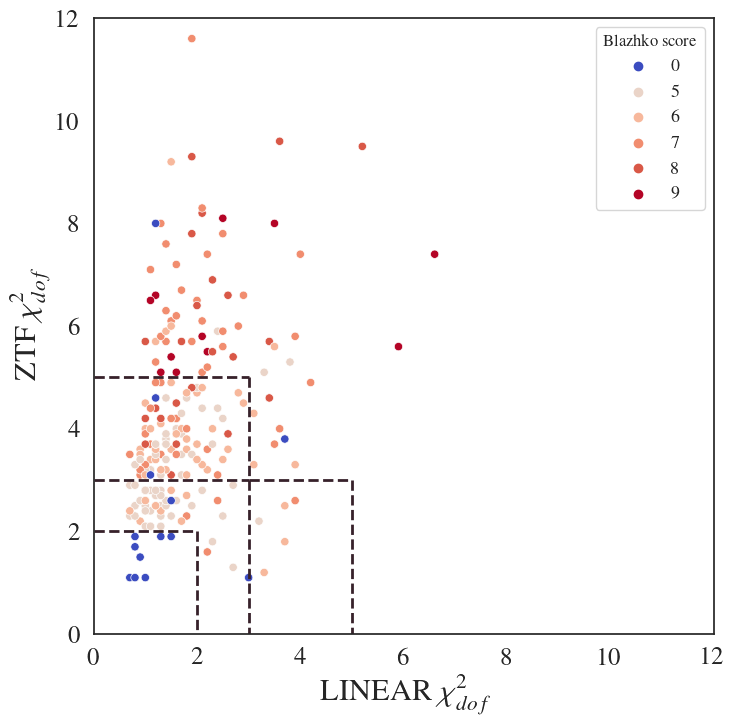

In [18]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(xscale='linear', yscale='linear') 
ax.xaxis.set_tick_params(labelsize=18) 
ax.yaxis.set_tick_params(labelsize=18) 
plt.rc('font', size=24) 

#sns.scatterplot(data=lc_analysis, x='L_chi2dofR', y='Zchi2dofR', marker='x', color=b1)
sns.scatterplot(data=be_MAIN, x='L_chi2r', y='Z_chi2r', marker='o', hue='B_score', palette='coolwarm')

plt.xlim([0, 12.0]) # limit of 20.0, because above 20.0 there is no point, something is wrong with the data
plt.ylim([0, 12.0])
plt.xlabel(r'LINEAR $\chi_{dof}^2$', fontproperties=font, fontsize=22)
plt.ylabel(r'ZTF $\chi_{dof}^2$', fontproperties=font,fontsize=22)

#plt.plot([3.0, 3.0], [0, 20.0], ls='--', c=black1)
#plt.plot([0, 20.0], [2.0, 2.0], ls='--', c=black1)
#plt.plot([5.0, 5.0], [20.0, 0.0], ls='--', c=black1)
#plt.plot([5.0, 3.0], [3.0, 3.0], ls='--', c=black1)
plt.plot([0.0, 3.0], [5.0, 5.0], ls='--', c=black1, lw=2)
plt.plot([3.0, 3.0], [5.0, 3.0], ls='--', c=black1, lw=2)
plt.plot([3.0, 5.0], [3.0, 3.0], ls='--', c=black1, lw=2)
plt.plot([5.0, 5.0], [3.0, 0.0], ls='--', c=black1, lw=2)

plt.plot([0.0,3.0], [3.0, 3.0], ls='--', c=black1, lw=2)
plt.plot([3.0,3.0], [3.0, 0.0], ls='--', c=black1, lw=2)
plt.plot([0.0,2.0], [2.0, 2.0], ls='--', c=black1, lw=2)
plt.plot([2.0,2.0], [2.0, 0.0], ls='--', c=black1, lw=2)
plt.legend(fontsize=13, title='Blazhko score')
plt.savefig('../images_paper/final_chi2_b.png', dpi=150)
#
plt.show()

In [ ]:
# Algorithm success:

print('The success of the selection algorithm is:', (len(be_MAIN['LINEAR ID']) / len(b_can['LINEAR ID']))*100,'%')

In [ ]:
# Incidence rate:

print('The incidence rate of Blazhko stars is:', (len(be_MAIN['LINEAR ID']) / rrlyrae.shape[0])*100,'%')

7.752465147908874 %


---

### The proportions of RRAB and RRC type stars

In [74]:
# lc type:
lc_type = be_MAIN['LCtype'].value_counts()
lc_type

1    180
2     48
Name: LCtype, dtype: int64

In [ ]:
lc_type = be_MAIN['LCtype'].value_counts()
print('Percentage of RRAB stars is ', (lc_type[0]/(lc_type[0]+lc_type[1]))*100, '%')
print('Percentage of RRC stars is ', (lc_type[1]/(lc_type[0]+lc_type[1]))*100, '%')


Percentage of RRAB stars is  78.94736842105263 %
Percentage of RRC stars is  21.052631578947366 %


----

# Cumulative plot

In [16]:
ztf_data = np.load("../outputs/ZTF_dataset_"+end+".npy", allow_pickle=True)

In [ ]:
def plotCDFs(pALL, pCan, pBlazh, aALL, aCan, aBlazh, mALL, mCan, mBlazh, title=""): 
    
    if title=="": 
        title = 'Cumulative distributions of period, amplitude and apparent mean magnitude (ZTF data)'
    fig, ax = plt.subplots(1,3, figsize=(28,9))   # dimensions of plot
    fig.set_facecolor('white') # background color
    fig.suptitle(title, fontproperties=font, fontsize=30)

    # PERIOD
    ax[0].ecdf(pALL, label="complete",color=b1,lw=2,ls='--')
    ax[0].ecdf(pCan, label="candidates",color=b4,lw=2,ls='-.')
    ax[0].ecdf(pBlazh, label="Blazhko stars",color=or4,lw=2)
    ax[0].set_xlabel('Period (day)', fontproperties=font, fontsize=25)
    ax[0].set_ylabel(r'$p( <x )$', fontproperties=font, fontsize=25)
    ax[0].tick_params(labelsize=20)

    # AMPL 
    ax[1].ecdf(aALL, label="complete",color=b1,lw=2,ls='--')
    ax[1].ecdf(aCan, label="candidates",color=b4,lw=2,ls='-.')
    ax[1].ecdf(aBlazh, label="Blazhko stars",color=or4,lw=2)
    ax[1].set_xlabel('Amplitude (mag)', fontproperties=font, fontsize=25)
    ax[1].tick_params(labelsize=20)

    # AVG MAG
    ax[2].ecdf(mALL, label="complete",color=b1,lw=2,ls='--')
    ax[2].ecdf(mCan, label="candidates",color=b4,lw=2,ls='-.')
    ax[2].ecdf(mBlazh, label="Blazhko stars",color=or4,lw=2)
    ax[2].tick_params(labelsize=20)
    ax[2].set_xlabel('Mean ZTF g mag', fontproperties=font, fontsize=25)

    ax[0].legend(fontsize=24)
    ax[1].legend(fontsize=24)
    ax[2].legend(fontsize=24)
    fig.tight_layout()
    plt.savefig('../images_paper/cumulative_distrib.png', dpi=250,bbox_inches = 'tight')
    plt.show()

In [ ]:
def getCDFinputsZTF(dfAll, ztf_data,  RRLyrType=-1):
    if RRLyrType > -1: 
        df = dfAll[dfAll['LCtype']==RRLyrType]
    else:
        df = dfAll
    period = df['Pztf'].to_numpy() # ztf period
    ampl = df['Zampl'].to_numpy() #just ztf data, not specific for any band
    values = np.array(())
    mag = []
    for i in df['LINEAR ID']:
        for j in ztf_data:
            if i == j[0]:
                BandData = j[1].loc[j[1]['filtercode'] == 'zg']
                magZ = BandData['mag'].to_numpy()
                avg = np.mean(magZ)
                if avg > 0:
                    mag.append(avg)   
    return period, ampl, mag 

In [ ]:
RRLyrType = 'all'

In [ ]:
pAll, aAll, mAll = getCDFinputsZTF(lc_MASTERd, ztf_data)

In [ ]:
pCan, aCan, mCan = getCDFinputsZTF(b_can, ztf_data)

In [ ]:
pBlazh, aBlazh, mBlazh = getCDFinputsZTF(be_MAIN, ztf_data)

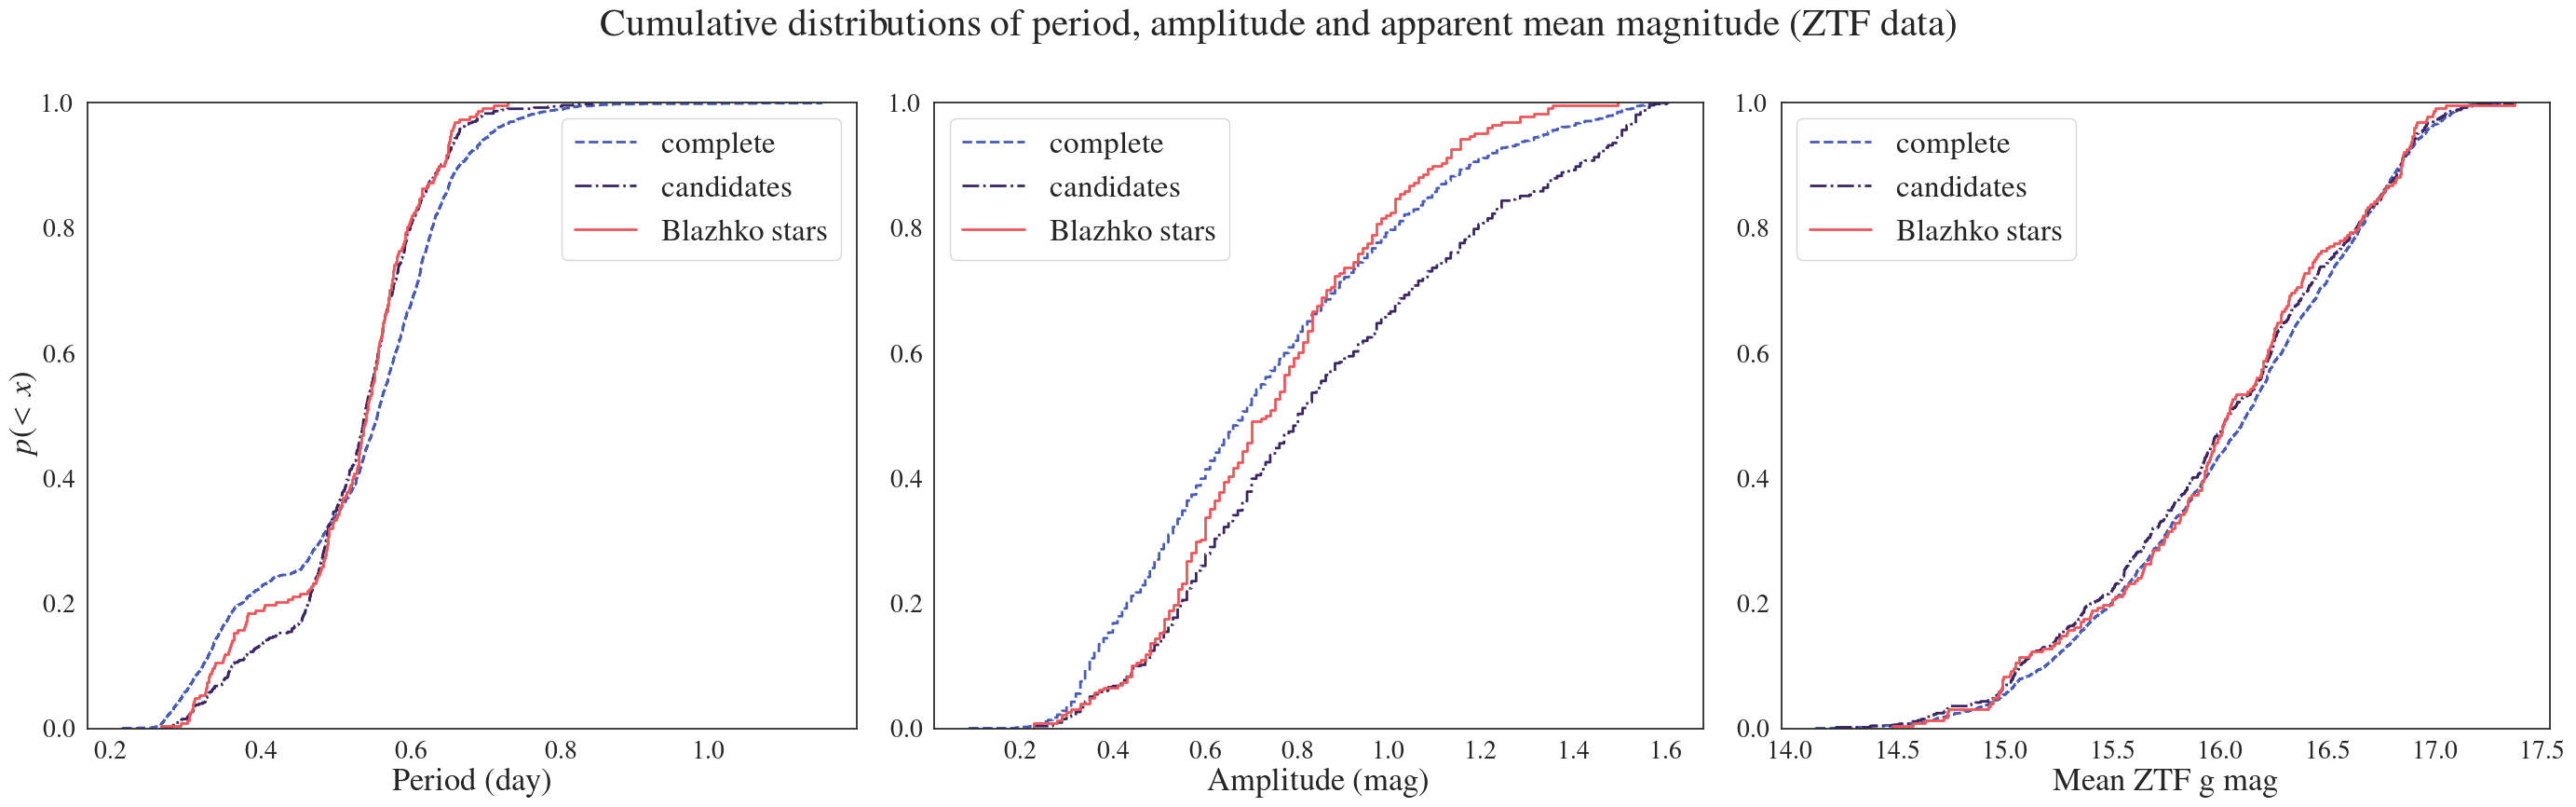

In [ ]:
plotCDFs(pAll, pCan, pBlazh, aAll, aCan, aBlazh, mAll, mCan, mBlazh)

In [ ]:
RRLyrType = 1
title = 'ab type RR Lyrae (ZTF data)'
pAll, aAll, mAll = getCDFinputsZTF(lc_MASTERd, ztf_data, RRLyrType)
pCan, aCan, mCan = getCDFinputsZTF(b_can, ztf_data, RRLyrType)
pBlazh, aBlazh, mBlazh = getCDFinputsZTF(be_MAIN, ztf_data, RRLyrType)

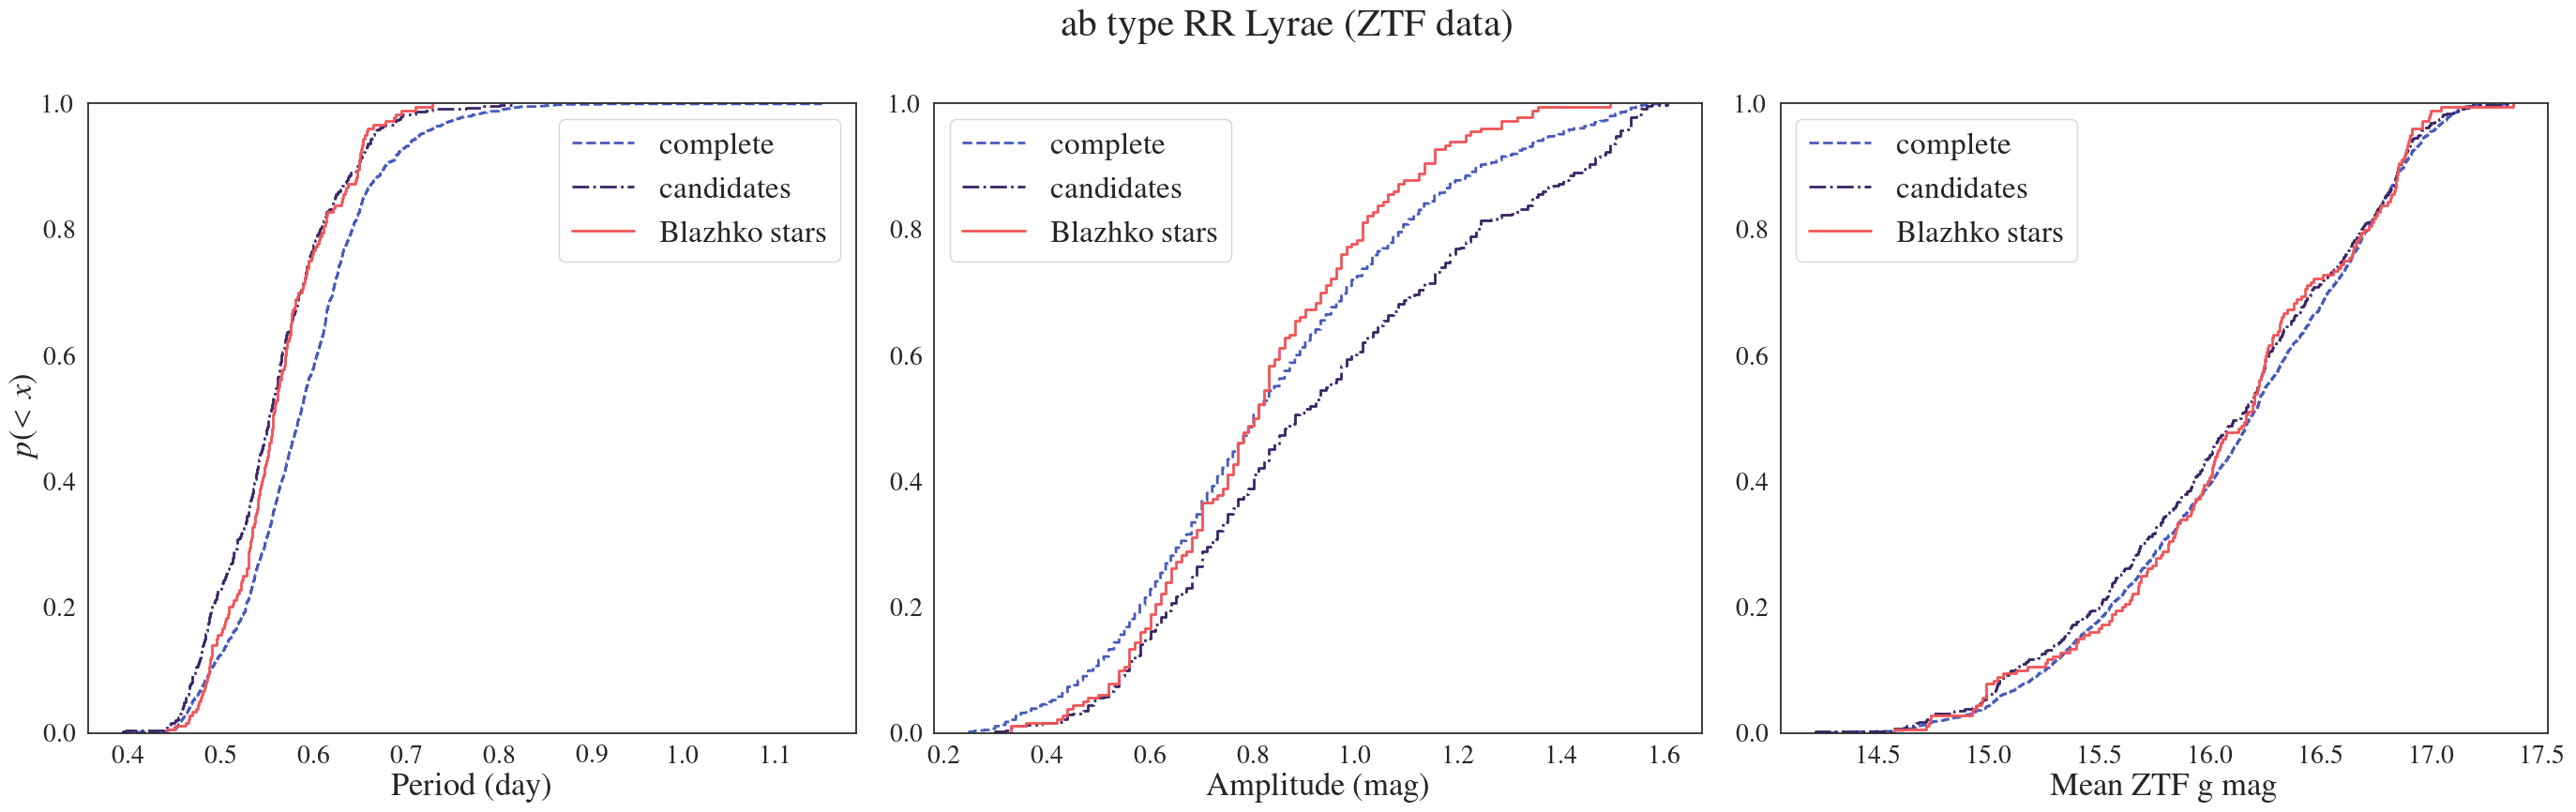

In [ ]:
plotCDFs(pAll, pCan, pBlazh, aAll, aCan, aBlazh, mAll, mCan, mBlazh, title)

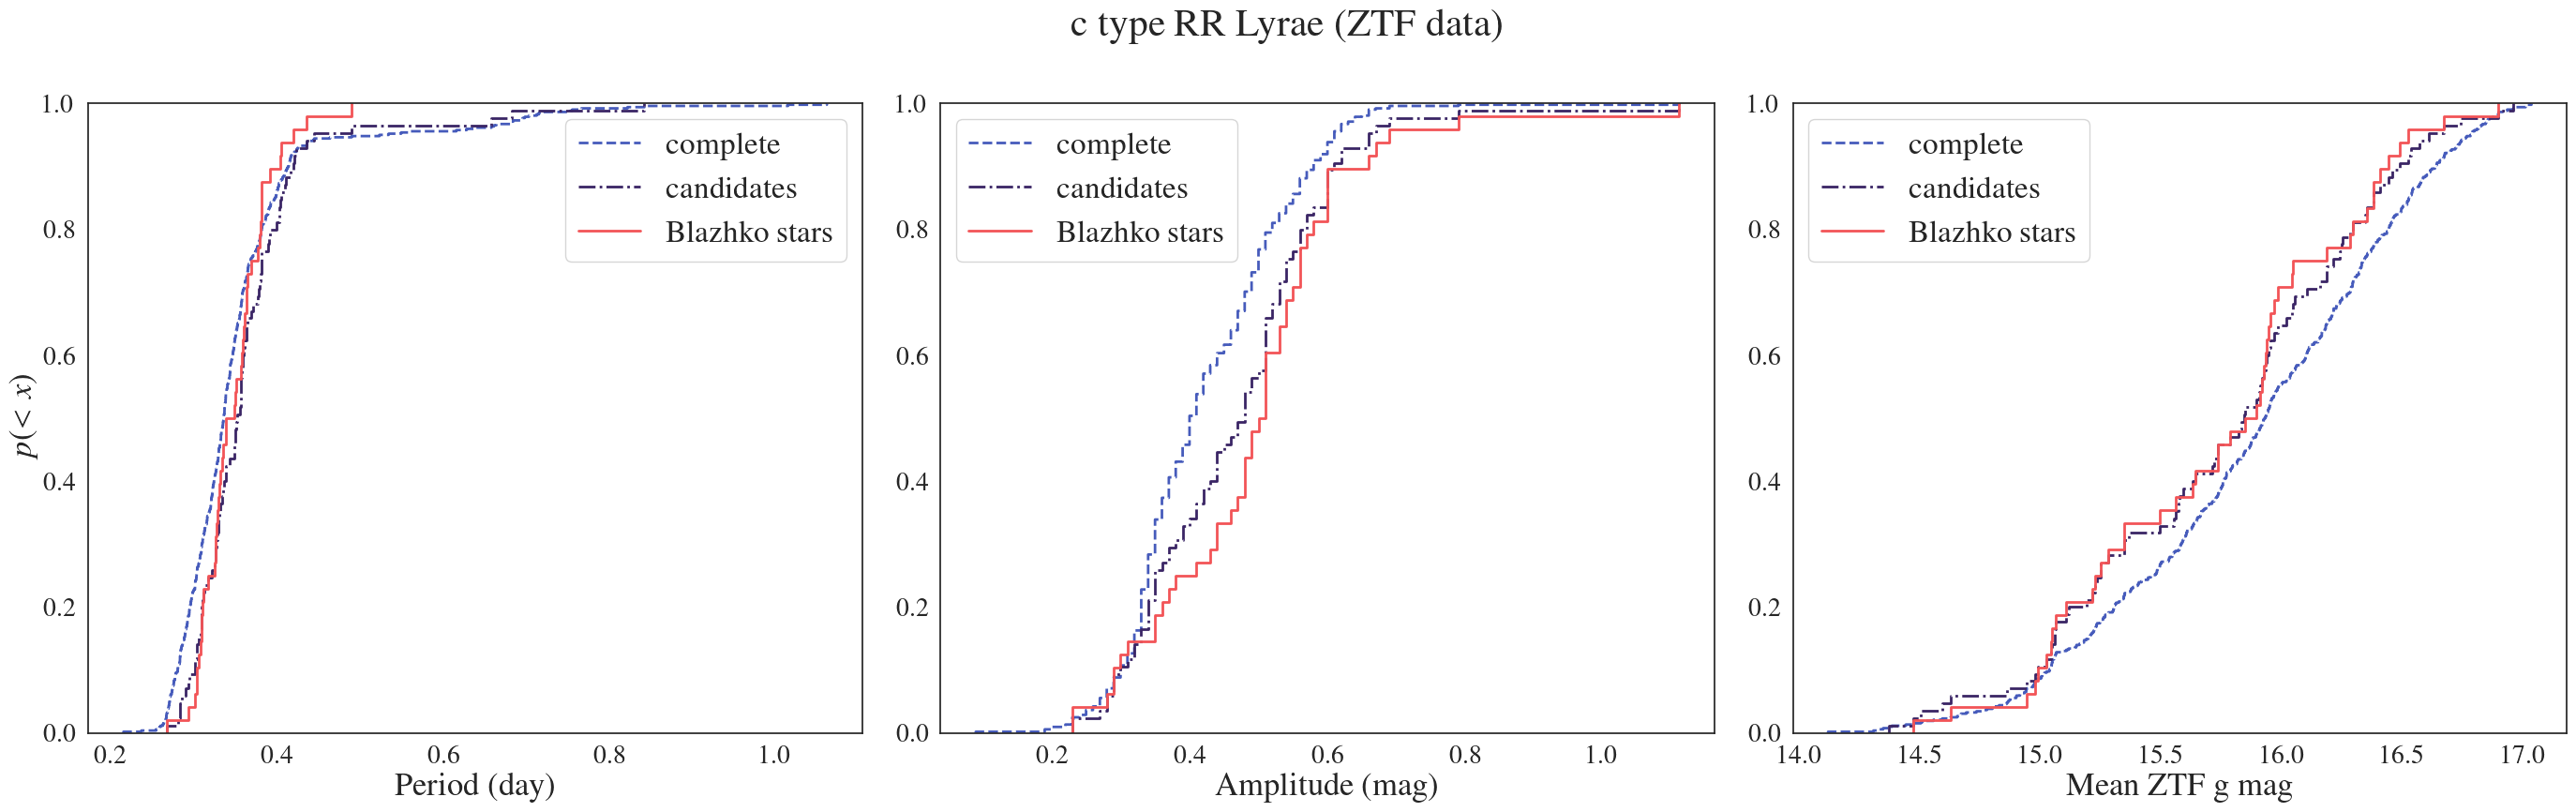

In [ ]:
RRLyrType = 2
title = 'c type RR Lyrae (ZTF data)'
pAll, aAll, mAll = getCDFinputsZTF(lc_MASTERd, ztf_data, RRLyrType)
pCan, aCan, mCan = getCDFinputsZTF(b_can, ztf_data, RRLyrType)
pBlazh, aBlazh, mBlazh = getCDFinputsZTF(be_MAIN, ztf_data, RRLyrType)
plotCDFs(pAll, pCan, pBlazh, aAll, aCan, aBlazh, mAll, mCan, mBlazh, title)

---

### Calculations of statistics for Blazhko stars

In [ ]:
amp_allL = lc_MASTERd['Lampl'].to_numpy()
amp_allZ = lc_MASTERd['Zampl'].to_numpy()
amp_bL = be_MAIN['Lampl'].to_numpy()
amp_bZ = be_MAIN['Zampl'].to_numpy()


period_allL = lc_MASTERd['Plinear'].to_numpy()
period_allZ = lc_MASTERd['Pztf'].to_numpy()
period_bL = be_MAIN['Plinear'].to_numpy()
period_bZ = be_MAIN['Pztf'].to_numpy()

blazhko_score = be_MAIN['B_score'].to_numpy()

In [ ]:
Pall = period_allZ[(period_allZ<0.45)&(amp_allZ<0.7)]
PB = period_bZ[(period_bZ<0.45)&(amp_bZ<0.7)]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))

In [ ]:
Pall = period_allZ[period_allZ>0.45]
PB = period_bZ[period_bZ>0.45]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))

In [ ]:
Pall = period_allL[amp_allZ>(2.4-4*period_allZ)]
PB = period_bL[amp_bZ>(2.4-4*period_bZ)]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))
# print(-0.03015/0.00427578)   # ab
#print(0.0051/0.00485)     # c 
print(-0.02705/0.00427581)

In [ ]:
print(0.0054799/0.004851473)
print(-0.030067000/0.00421457)

In [ ]:
Pall = amp_allZ[period_allZ>0.45]
PB = amp_bZ[period_bZ>0.45]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))
print(0.010000/0.01695470)

In [ ]:
Pall = amp_allL[amp_allZ<(2.4-4*period_allZ)]
PB = amp_bL[amp_bZ<(2.4-4*period_bZ)]
print(np.median(Pall), np.median(PB), np.median(PB)/np.median(Pall), np.median(PB)-np.median(Pall))
print(np.std(PB), len(PB), np.std(PB)/np.sqrt(len(PB)))
# print(0.005000/0.01677)  # ab
print(0.085000/0.0169)    # c 

In [ ]:
Xlc_MASTERd = lc_MASTERd[lc_MASTERd['LCtype']==1]
Xbe_MAIN = be_MAIN[be_MAIN['LCtype']==1]
print(len(Xlc_MASTERd), len(Xbe_MAIN), len(Xbe_MAIN)/len(Xlc_MASTERd))

In [ ]:
ab = Xlc_MASTERd[Xlc_MASTERd['Zampl']>(2.4-4*Xlc_MASTERd['Pztf'])]
print(len(ab))

In [ ]:
Xlc_MASTERd = lc_MASTERd[lc_MASTERd['LCtype']==2]
Xbe_MAIN = be_MAIN[be_MAIN['LCtype']==2]
print(len(Xlc_MASTERd), len(Xbe_MAIN), len(Xbe_MAIN)/len(Xlc_MASTERd))

In [ ]:
c = Xlc_MASTERd[Xlc_MASTERd['Zampl']<(2.4-4*Xlc_MASTERd['Pztf'])]
print(len(c))

In [ ]:
print(np.sqrt(180)/1474)

---

# Which images contain the effect for which dataset?

In [14]:
effect_present = ['B','B','L','L','L','L','B',
    'L','B','L','L','B','L','L','B','Z','Z','L',
    'B','L','L','B','Z','L','Z','L','B','Z','B',
    'B','L','L','B','Z','B','L','B','L','L','B','L',
    'L','L','Z','B','B','B','Z','Z','B','Z','B',
    'L','L','Z','Z','Z','B','B','Z','B','B','Z',
    'B','B','Z','B','B','B','L','B','Z','B','B',
    'B','L','L','B','B','B','Z','B','L','L','L',
    'B','L','B','B','L','L','B','L','B','B','B',
    'L','L','B','Z','Z','Z','B','Z','L','B','B',
    'B','B','B','B','L','Z','B','B','Z','B','L',
    'L','Z','Z','B','B','B','Z','Z','B','L','B',
    'L','Z','L','B','Z','Z','Z','Z','Z','Z','Z',
    'Z','B','Z','Z','Z','Z','L','B','B','B','Z',
    'B','B','B','Z','B','Z','Z','Z','Z','B','B',
    'Z','B','Z','Z','L','B','B','L','B','B','Z',
    'Z','B','Z','Z','B','B','L','B','Z','B','Z',
    'Z','Z','Z','Z','B','Z','Z','L','B','L','B',
    'Z','Z','B','Z','B','Z','L','B','B','B','B',
    'B','B','L','L','B','B','B','L','B','L','B',
    'B','B','L','B','B','L','B','L','Z','L','B'
]

In [16]:
be_MAIN['Presence'] = effect_present
be_MAIN.head()

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,...,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f,Presence
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,...,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1,B
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,...,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1,B
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,...,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1,L
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,...,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1,L
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,...,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1,L


In [169]:
be_MAIN.to_csv('../outputs/be_MAIN_presence.csv', index=False)

---

# Contour plot

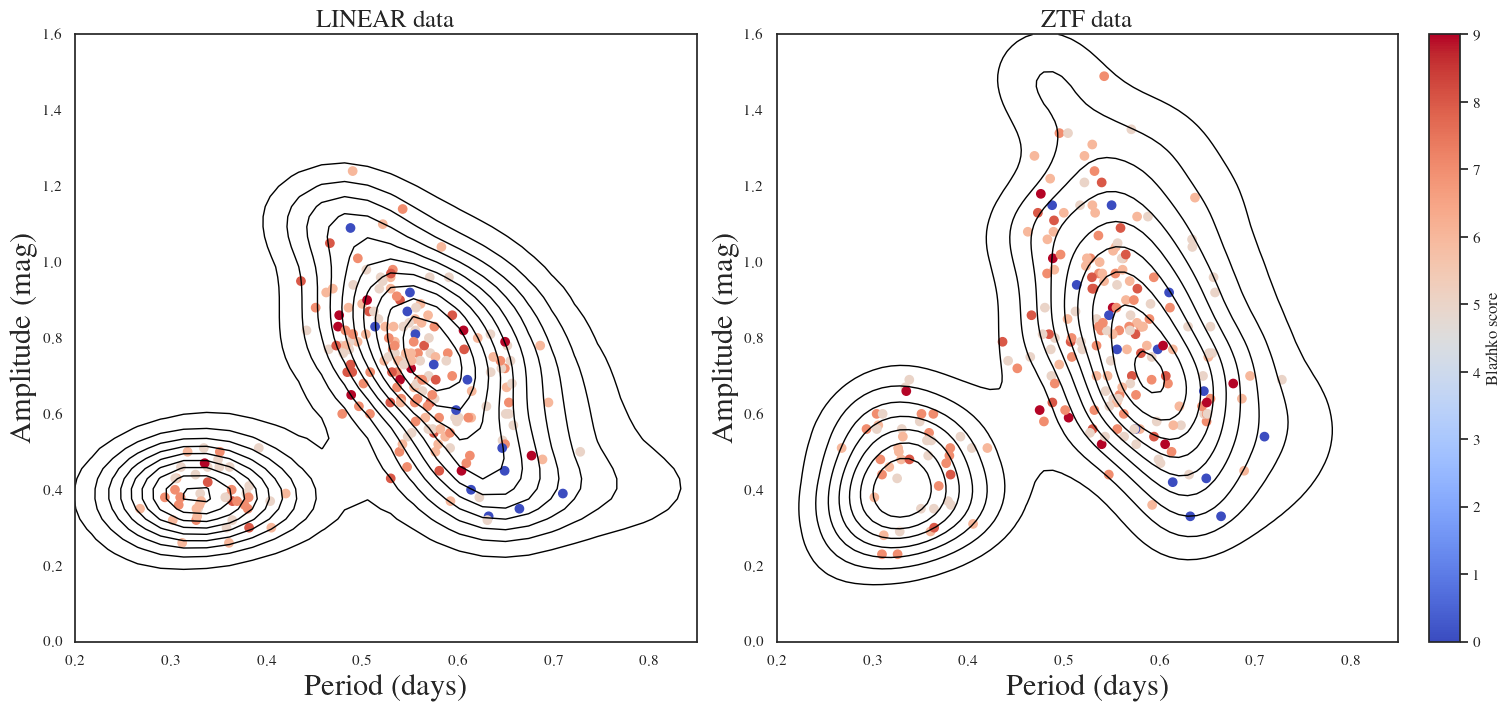

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,7), constrained_layout=True)   # dimensions of plot
fig.set_facecolor('white') # background color

amp_allL = lc_MASTERd['Lampl'].to_numpy()
amp_allZ = lc_MASTERd['Zampl'].to_numpy()
amp_bL = be_MAIN['Lampl'].to_numpy()
amp_bZ = be_MAIN['Zampl'].to_numpy()


period_allL = lc_MASTERd['Plinear'].to_numpy()
period_allZ = lc_MASTERd['Pztf'].to_numpy()
period_bL = be_MAIN['Plinear'].to_numpy()
period_bZ = be_MAIN['Pztf'].to_numpy()

blazhko_score = be_MAIN['B_score'].to_numpy()

# --------

xy = np.vstack([amp_allL, period_allL])
density = gaussian_kde(xy)(xy)

x = np.linspace(min(amp_allL), max(amp_allL), 100)
y = np.linspace(min(period_allL), max(period_allL), 100)
X, Y = np.meshgrid(x, y)

Z = gaussian_kde(xy)(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

num_levels = 12  
levels = np.linspace(Z.min(), Z.max(), num_levels)

#ax[0].contour(X, Y, Z, levels=levels, colors="black", linewidths=1)  
#scatter = ax[0].scatter(amp_bL, period_bL, c=blazhko_score, cmap="coolwarm")
ax[0].contour(Y, X, Z, levels=levels, colors="black", linewidths=1)  
scatter = ax[0].scatter(period_bL, amp_bL, c=blazhko_score, cmap="coolwarm")


ax[0].set_xlim([0.2,0.85])
ax[0].set_ylim([0,1.6])

ax[0].set_title('LINEAR data', fontproperties=font, fontsize=18)
ax[0].set_xlabel('Period (days)',fontproperties=font, fontsize=22)
ax[0].set_ylabel('Amplitude (mag)',fontproperties=font, fontsize=22)
# ===================

xy2 = np.vstack([amp_allZ, period_allZ])
density = gaussian_kde(xy2)(xy2)

x2 = np.linspace(min(amp_allZ), max(amp_allZ), 100)
y2 = np.linspace(min(period_allZ), max(period_allZ), 100)
X2, Y2 = np.meshgrid(x2, y2)

Z2 = gaussian_kde(xy2)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

levels2 = np.linspace(Z2.min(), Z2.max(), num_levels)

#ax[1].contour(X2, Y2, Z2, levels=levels, colors="black", linewidths=1) 
#scatter2 = ax[1].scatter(amp_bZ, period_bZ, c=blazhko_score, cmap="coolwarm")
ax[1].contour(Y2, X2, Z2, levels=levels, colors="black", linewidths=1) 
scatter2 = ax[1].scatter(period_bZ, amp_bZ, c=blazhko_score, cmap="coolwarm")

ax[1].set_xlim([0.2,0.85])
ax[1].set_ylim([0,1.6])

ax[1].set_title('ZTF data', fontproperties=font, fontsize=18)
ax[1].set_xlabel('Period (days)',fontproperties=font, fontsize=22)
ax[1].set_ylabel('Amplitude (mag)',fontproperties=font, fontsize=22)
plt.colorbar(scatter2, label="Blazhko score")
plt.savefig('../images_paper/contour_plot_amp_periodZI.png', dpi=300, bbox_inches = 'tight')
plt.show()

---

## Checking if all of our stars are new blazhko stars

In [ ]:
# loading a .csv file with RA and DEC coordinates of all previously found field blazhko stars
ra_dec = pd.read_csv('../inputs/ra dec.csv', sep=';', dtype=str)

In [86]:
ra_dec.head()

,NAME,RA,DEC
0,GV Peg,000035.59,263949.5
1,J000157.75-364042.4,000157.75,-364042.4
2,RU Scl,000248.11,-245643.1
3,CSSJ000736.5-081444,000736.5,-81444
4,RY Psc,001141.10,-014455.3


In [ ]:
# manipulating the values in the table to get the correct format
value2 = ra_dec['DEC'][3]

is_negative = value2.startswith('-')

no_decimal = "." in value2

value2 = value2.replace('-', '').replace(' ', '')

if no_decimal == False:
    deg = float(value2[:2])
    arcminutes = float(value2[2:4])
    arcseconds = float(value2[4:])

In [ ]:
for i in range(ra_dec.shape[0]):
    
    # converting the RA coordinates into degree format
    value = ra_dec['RA'][i]

    value = value.replace(' ', '')
    hours = float(value[:2])
    minutes = float(value[2:4])
    seconds = float(value[4:])

    new_value = (hours + minutes/60 + seconds/3600)*15

    ra_dec['RA'][i] = new_value

    # -------

    # converting the DEC coordinates into degree format
    value2 = ra_dec['DEC'][i]

    is_negative = value2.startswith('-')
    value2 = value2.replace('-', '').replace(' ', '')

    deg = float(value2[:2])
    arcminutes = float(value2[2:4])
    arcseconds = float(value2[4:])

    # adjusting for negative values
    if is_negative:
        new_value2 = deg + arcminutes/60 + arcseconds/3600
        new_value2 = -new_value2
    else:
        new_value2 = deg + arcminutes/60 + arcseconds/3600

    ra_dec['DEC'][i] = new_value2

In [91]:
be_IDS = list(be_MAIN['LINEAR ID'])

In [ ]:
# creating a new table with correct values for RA and DEC
ra_dec_orig = pd.DataFrame(columns=['ID', 'RA', 'DEC'])
ID, RA, DEC = [], [], []
for i in be_IDS:
    for j in dataL.targets:
        if i == j[0]:
            ID.append(j[0])
            RA.append(j[3])
            DEC.append(j[4])

ra_dec_orig['ID'] = ID
ra_dec_orig['RA'] = RA
ra_dec_orig['DEC'] = DEC

In [94]:
ra_dec_orig.head()

,ID,RA,DEC
0,158779,120.751266,51.866173
1,263541,123.002663,40.655533
2,393084,125.665428,25.988720
3,810169,127.450302,51.852364
4,924301,169.431274,3.723548


In [ ]:
# creating a new column to flag old stars, but default value is New
ra_dec_orig['Flag'] = ['New' for x in range(ra_dec_orig.shape[0])]

In [ ]:
# looping through the original table and the new table to check if the coordinates are the same
for i in range(ra_dec_orig.shape[0]):
    for j in range(ra_dec.shape[0]):
        # converting the coordinates into the correct format for the list of stars known thus far
        coord1 = SkyCoord(ra=ra_dec_orig['RA'][i]*u.degree, 
                         dec=ra_dec_orig['DEC'][i]*u.degree)
        
        # converting the coordinates into the correct format for our list of blazhko field stars
        coord2 = SkyCoord(ra=ra_dec['RA'][j]*u.degree, 
                         dec=ra_dec['DEC'][j]*u.degree)
        
        # Calculate separation
        sep = coord1.separation(coord2)

        if sep < 10*u.arcsec:
            ra_dec_orig['Flag'][i] = 'Old'
            break

/var/folders/t5/p2kd2rtd7bz4dz4p833qfm3w0000gn/T/ipykernel_44798/3907988883.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ra_dec_orig['Flag'][i] = 'Old'


In [99]:
ra_dec_orig['Flag'].value_counts()

New    227
Old      1
Name: Flag, dtype: int64

In [100]:
ra_dec_orig[ra_dec_orig["Flag"] == "Old"]

,ID,RA,DEC,Flag
173,17919686,244.643082,27.470318,Old


Only one star has previously been found in another catalogue!

---